In [1]:
pwd

'/Users/peterhaglich/Dropbox/Work/IARPA/Mercury/peterhaglich/mercury-challenge/src/notebooks/GSR'

In [2]:
%matplotlib inline

In [3]:
import os
import json
import sys
import re

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("fivethirtyeight")

from dateutil.parser import parse
import datetime

from geopy.distance import vincenty

In [4]:
REFERENCE_WEEKDAY = 3 #Wednesday

def iso_year_start(iso_year):
    """The gregorian calendar date of the first day of the given ISO year
    :param iso_year: The ISO year for which we are trying to find the starting date
    :return: First day of the ISO year.
    """
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta


def iso_to_gregorian(iso_year, iso_week, iso_day):
    """Gregorian calendar date for the given ISO year, week and day
    :param iso_year: ISO Year
    :param iso_week: ISO Week
    :param iso_day: ISO Day
    :return: Gregorian date for the given ISO Year/Week/Day
    """
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


def isoweek_to_gregorian(iso_week):
    """Takes (year, week, day) object and calls iso_to_gregorian"""
    yy = iso_week[0]
    ww = iso_week[1]
    dd = iso_week[2]
    return iso_to_gregorian(yy, ww, dd)


def convert_to_refday(dd, refday=REFERENCE_WEEKDAY):
    """
    Determines the reference day for the given ISO day
    :param dd: Date of interest
    :param refday: Reference day for ISO weeks.  Default is REFERENCE_WEEKDAY
    :return: Gregorian date for reference day for the given ISO day
    """
    dd_iso = dd.isocalendar()
    ref_iso = (dd_iso[0], dd_iso[1], refday)
    ref_date = iso_to_gregorian(*ref_iso)
    return ref_date



In [7]:
MERC_HOME = os.path.abspath("../../../../mercury/")
print(MERC_HOME)
print(os.listdir(MERC_HOME))
MERC_DATA_PATH = os.path.join(MERC_HOME, "data")
MERC_GSR_PATH = os.path.join(MERC_DATA_PATH, "gsr")
MERC_CU_PATH = os.path.join(MERC_GSR_PATH, "cu_gsr")
MCT_HOME = os.path.join("..", "..", "..", "..", "..")
MCT_DATA_PATH = os.path.join(MCT_HOME, "data")
MCT_GSR_PATH = os.path.join(MCT_DATA_PATH, "gsr")
MCT_CU_PATH = os.path.join(MCT_GSR_PATH, "cu_gsr")
MCT_CU_COUNT_PATH = os.path.join(MCT_GSR_PATH, "cu_count_gsr")
MCT_SRC_PATH = os.path.join(MCT_HOME, "scoring_code", "src", 
                            "main", "python", "mercury", "scoring")
MCT_DOC_PATH = os.path.join(MCT_HOME, "doc")
MCT_PLOT_PATH = os.path.join(MCT_DOC_PATH, "GSR Plots")

TAHRIR_COORD = {"latitude": 30.04444,
                "longitude": 31.2357}


/Users/peterhaglich/Dropbox/Work/IARPA/Mercury/peterhaglich/mercury
['.DS_Store', '.git', '.gitignore', '.idea', 'data', 'doc', 'MANSA_February_2017.json', 'pete_mercury_conda.txt', 'pete_mercury_conda.yml', 'README.md', 'scoring_code']


In [12]:
cu_gsr = []
cu_files = [x for x in os.listdir(MERC_CU_PATH) if "Dup" not in x
            if x.startswith("CU")]
cu_files

['CU_04_September_2018.json',
 'CU_07_August_2018.json',
 'CU_10_July_2018.json',
 'CU_18_September_2018.json',
 'CU_21_August_2018.json',
 'CU_24_July_2018.json',
 'CU_April_2016.json',
 'CU_April_2017.json',
 'CU_April_2018.json',
 'CU_August_2015.json',
 'CU_August_2016.json',
 'CU_August_2017.json',
 'CU_December_2015.json',
 'CU_December_2016.json',
 'CU_December_2017.json',
 'CU_February_2016.json',
 'CU_February_2017.json',
 'CU_February_2018.json',
 'CU_January_2016.json',
 'CU_January_2017.json',
 'CU_January_2018.json',
 'CU_July_2015.json',
 'CU_July_2016.json',
 'CU_July_2017.json',
 'CU_June_2015.json',
 'CU_June_2016.json',
 'CU_June_2017.json',
 'CU_June_2018.json',
 'CU_March_2016.json',
 'CU_March_2017.json',
 'CU_March_2018.json',
 'CU_May_2015.json',
 'CU_May_2016.json',
 'CU_May_2017.json',
 'CU_May_2018.json',
 'CU_November_2015.json',
 'CU_November_2016.json',
 'CU_November_2017.json',
 'CU_October_2015.json',
 'CU_October_2016.json',
 'CU_October_2017.json',
 'CU

In [13]:
for file_ in cu_files:
    path_ = os.path.join(MERC_CU_PATH, file_)
    with open(path_, "r", encoding="utf-8-sig") as f:
        try:
            gsr_ = json.load(f)
            cu_gsr += gsr_
        except json.JSONDecodeError:
            print(file_)

In [14]:
cu_gsr_df = pd.DataFrame(cu_gsr)

cu_gsr_df = cu_gsr_df[cu_gsr_df.Violent == "False"]
cu_gsr_df = cu_gsr_df[cu_gsr_df.Event_Type == "Civil Unrest"]

In [9]:
# Replace duplicated event IDs with the latest version.
cu_gsr_df["Revision_DTG"] = cu_gsr_df.Revision_Date.apply(parse)
for ed, group in cu_gsr_df.groupby("Event_ID"):
    newest_index = group.Revision_DTG.argmax()
    newest_rev_date = group.Revision_Date[newest_index]
    cu_gsr_df.set_value(group.index[0], "Revision_Date", newest_rev_date)
cu_gsr_df.drop("Revision_DTG", axis=1, inplace=True)
cu_gsr_df.drop_duplicates(subset="Event_ID", keep="last", inplace=True)

In [10]:
cu_gsr_df.Country.value_counts()

Egypt     6214
Jordan    1653
Name: Country, dtype: int64

In [11]:
eg_gsr_df = cu_gsr_df[cu_gsr_df.Country == "Egypt"]
print("There are {} events in Egypt".format(len(eg_gsr_df)))
jo_gsr_df = cu_gsr_df[cu_gsr_df.Country == "Jordan"]
print("There are {} events in Jordan".format(len(jo_gsr_df)))
amman_df = jo_gsr_df[jo_gsr_df.State == "Amman"]
print("There are {} events in the province of Amman".format(len(amman_df)))
madaba_df = jo_gsr_df[jo_gsr_df.State == "Madaba"]
print("There are {} events in the province of Madaba".format(len(madaba_df)))
irbid_df = jo_gsr_df[jo_gsr_df.State == "Irbid"]
print("There are {} events in the province of Irbid".format(len(irbid_df)))

There are 6214 events in Egypt
There are 1653 events in Jordan
There are 459 events in the province of Amman
There are 89 events in the province of Madaba
There are 281 events in the province of Irbid


Compute the date range spanning the event history

In [12]:
day_1 = cu_gsr_df.Event_Date.min()
day_N = cu_gsr_df.Event_Date.max()
print(day_1, day_N)
dr_ = pd.date_range(day_1, day_N)

2015-05-01 2018-04-30


Compute the dates corresponding to the weekly reference days

In [13]:
iso_dates = [x.isocalendar() for x in dr_]
iso_dates = [(x[0], x[1], REFERENCE_WEEKDAY) for x in iso_dates]
iso_dates = sorted(set(iso_dates))
iso_dates = [isoweek_to_gregorian(x) for x in iso_dates]
print(parse(day_1).isocalendar(), parse(day_N).isocalendar())
print(iso_dates[0], iso_dates[-1])

(2015, 18, 5) (2018, 18, 1)
2015-04-29 2018-05-02


Compute the dates corresponding to the monthly reference days

In [14]:
month_dates = [x.replace(day=1).date() for x in dr_]
month_dates = sorted(set(month_dates))
print(month_dates[0], month_dates[-1])

2015-05-01 2018-04-01


In [15]:
cu_gsr_df.head()

,Approximate_Location,City,Country,Crowd_Size,Crowd_Size_Description,Earliest_Reported_Date,Encoding_Comment,Event_Date,Event_ID,Event_Type,...,GSS_Link,Latitude,Longitude,News_Source,Other_Links,Population,Reason,Revision_Date,State,Violent
0,False,El Gouna,Egypt,Unknown,None,2017-06-01,None,2017-06-01,CU56213,Civil Unrest,...,http://www.almasryalyoum.com/news/details/1142615,27.3942,33.6782,Al-Masry Al-Youm,None,Legal;Medical,Other Government Issues,2017-07-13,Red Sea,False
1,False,Al Jīzah,Egypt,Large,None,2017-06-01,Crowd size is Tens in two locations.\rSied com...,2017-06-01,CU56215,Civil Unrest,...,http://www.youm7.com/story/2017/6/1/%D8%BA%D8%...,30.0081,31.2109,Youm7,None,Labor,Employment and Wages,2017-07-13,Al Jīzah,False
2,False,Ḩadā’iq al Qubbah,Egypt,Large,None,2017-06-01,Crowd size is Tens in two locations.\rMamfis c...,2017-06-01,CU56216,Civil Unrest,...,http://www.youm7.com/story/2017/6/1/%D8%BA%D8%...,30.0884,31.2835,Youm7,None,Labor,Employment and Wages,2017-07-13,Muḩāfaz̧at al Qāhirah,False
3,False,‘Izbat Nafīshah al Baḩrīyah,Egypt,Large,Tens,2017-06-01,None,2017-06-01,CU56100,Civil Unrest,...,https://m.alwafd.org/%D8%A7%D9%84%D9%85%D8%AD%...,30.5667,32.2333,Al-Wafd,None,General Population,Other Government Issues,2017-07-13,Al Ismā‘īlīyah,False
4,False,Al Manşūrah,Egypt,Large,Large,2017-06-02,None,2017-06-01,CU56101,Civil Unrest,...,http://www.ahram.org.eg/NewsPrint/597142.aspx,31.0364,31.3807,Al-Ahram,None,General Population,Other Civil Unrest,2017-07-13,Muḩāfaz̧at ad Daqahlīyah,False


## Export Deduplicated Monthly GSR

In [16]:
cu_gsr_df["YEARMON"] = cu_gsr_df.Event_Date.apply(lambda x: parse(x).strftime("%B_%Y"))
for yearmon in cu_gsr_df.YEARMON.unique():
    df_ = cu_gsr_df[cu_gsr_df.YEARMON == yearmon]
    df_.drop("YEARMON", axis=1, inplace=True)
    df_.drop("Violent", axis=1, inplace=True)
    out_filename = "CU_{}.json".format(yearmon)
    out_path = os.path.join(MCT_CU_PATH, out_filename)
    df_.to_json(force_ascii=False, orient="records", path_or_buf=out_path)


/anaconda3/envs/mercury/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/envs/mercury/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [17]:
df_.iloc[0].to_json(force_ascii=False)

'{"Approximate_Location":"True","City":"Al Ashrāf","Country":"Egypt","Crowd_Size":"Unknown","Crowd_Size_Description":null,"Earliest_Reported_Date":"2017-07-01","Encoding_Comment":"Part of widespread event.\\rThe location of the strike ca not be determined accurately. It could be in Qina city or Ashraaf village.","Event_Date":"2017-07-01","Event_ID":"CU56261","Event_Type":"Civil Unrest","First_Reported_Link":"http:\\/\\/www.almasryalyoum.com\\/news\\/details\\/1156327","GSS_Link":"http:\\/\\/www.almasryalyoum.com\\/news\\/details\\/1156327","Latitude":26.0958,"Longitude":32.7675,"News_Source":"Al-Masry Al-Youm","Other_Links":null,"Population":"Business","Reason":"Other Economic Issues","Revision_Date":"2017-08-09","State":"Qinā"}'

## Egypt Daily Counts

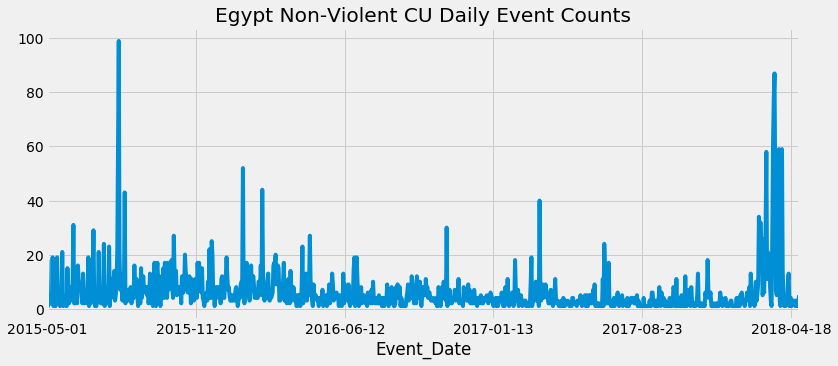

In [18]:
eg_daily = eg_gsr_df.groupby("Event_Date").size()
eg_daily.reindex(dr_).fillna(0)
eg_daily.plot(figsize=(12,5))
title_ = "Egypt Non-Violent CU Daily Event Counts"
plt.title(title_);
out_path = os.path.join(MCT_PLOT_PATH, "{}.png".format(title_))
plt.savefig(out_path)

In [19]:
out_path = os.path.join(MCT_CU_COUNT_PATH, "Egypt_Daily_Counts.json")

eg_daily_df = pd.DataFrame({"Case_Count": eg_daily})
eg_daily_df["Country"] = "Egypt"
eg_daily_df["Event_Date"] = eg_daily_df.index
eg_daily_df["Event_ID"] = eg_daily_df.apply(lambda x: "CU_Count_Egypt_{}".format(x.Event_Date),
                                            axis=1)
eg_daily_df.to_json(force_ascii=False, orient="records", path_or_buf=out_path)

## Tahrir Vicinity Weekly Counts

In [20]:
tahrir_df = eg_gsr_df.copy()
tahrir_df.head()

,Approximate_Location,City,Country,Crowd_Size,Crowd_Size_Description,Earliest_Reported_Date,Encoding_Comment,Event_Date,Event_ID,Event_Type,...,GSS_Link,Latitude,Longitude,News_Source,Other_Links,Population,Reason,Revision_Date,State,Violent
0,False,El Gouna,Egypt,Unknown,None,2017-06-01,None,2017-06-01,CU56213,Civil Unrest,...,http://www.almasryalyoum.com/news/details/1142615,27.3942,33.6782,Al-Masry Al-Youm,None,Legal;Medical,Other Government Issues,2017-07-13,Red Sea,False
1,False,Al Jīzah,Egypt,Large,None,2017-06-01,Crowd size is Tens in two locations.\rSied com...,2017-06-01,CU56215,Civil Unrest,...,http://www.youm7.com/story/2017/6/1/%D8%BA%D8%...,30.0081,31.2109,Youm7,None,Labor,Employment and Wages,2017-07-13,Al Jīzah,False
2,False,Ḩadā’iq al Qubbah,Egypt,Large,None,2017-06-01,Crowd size is Tens in two locations.\rMamfis c...,2017-06-01,CU56216,Civil Unrest,...,http://www.youm7.com/story/2017/6/1/%D8%BA%D8%...,30.0884,31.2835,Youm7,None,Labor,Employment and Wages,2017-07-13,Muḩāfaz̧at al Qāhirah,False
3,False,‘Izbat Nafīshah al Baḩrīyah,Egypt,Large,Tens,2017-06-01,None,2017-06-01,CU56100,Civil Unrest,...,https://m.alwafd.org/%D8%A7%D9%84%D9%85%D8%AD%...,30.5667,32.2333,Al-Wafd,None,General Population,Other Government Issues,2017-07-13,Al Ismā‘īlīyah,False
4,False,Al Manşūrah,Egypt,Large,Large,2017-06-02,None,2017-06-01,CU56101,Civil Unrest,...,http://www.ahram.org.eg/NewsPrint/597142.aspx,31.0364,31.3807,Al-Ahram,None,General Population,Other Civil Unrest,2017-07-13,Muḩāfaz̧at ad Daqahlīyah,False


In [21]:
def distance_from(lat, long, ref_lat, ref_long):
    place = (lat, long)
    ref_ = (ref_lat, ref_long)
    v = vincenty(place, ref_)
    return v.km

In [22]:
place_0 = tuple(tahrir_df.iloc[0][["Latitude", "Longitude"]])
print(place_0)
tahrir = (TAHRIR_COORD["latitude"], TAHRIR_COORD["longitude"])
distance_from(place_0[0], place_0[1], tahrir[0], tahrir[1])

(27.394200000000001, 33.678199999999997)


378.4206304046663

In [23]:
tahrir_df["Distance"] = tahrir_df.apply(lambda x: distance_from(x["Latitude"],
                                                                x["Longitude"],
                                                                tahrir[0],
                                                                tahrir[1]),
                                       axis=1)
tahrir_df=tahrir_df[tahrir_df.Distance <= 75.0]
print("There are {} events within 75 km of Tahrir Square".format(len(tahrir_df)))

There are 2206 events within 75 km of Tahrir Square


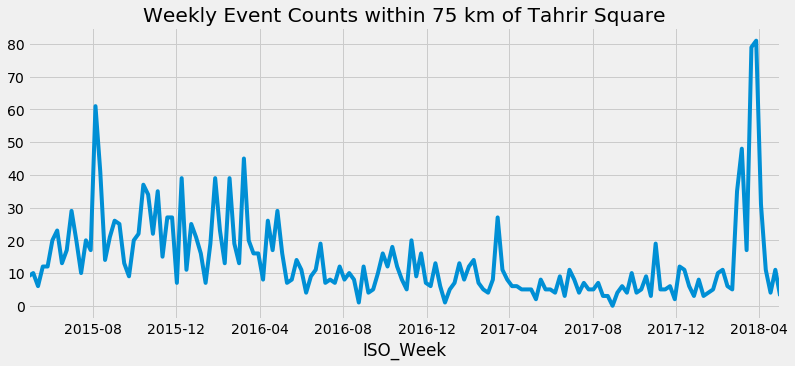

In [24]:
tahrir_df["ISO_Week"] = tahrir_df.Event_Date.apply(lambda x: parse(x).isocalendar())
tahrir_df["ISO_Week"] = tahrir_df.ISO_Week.apply(lambda x: (x[0], x[1], REFERENCE_WEEKDAY))
tahrir_df.ISO_Week = tahrir_df.ISO_Week.apply(isoweek_to_gregorian)
tahrir_by_week = tahrir_df.groupby("ISO_Week").size()
tahrir_by_week = tahrir_by_week.reindex(iso_dates).fillna(0)

tahrir_by_week.plot(figsize=(12,5))
title_ = "Weekly Event Counts within 75 km of Tahrir Square"
plt.title(title_);
out_path = os.path.join(MCT_PLOT_PATH, "{}.png".format(title_))
plt.savefig(out_path)

In [25]:
out_path = os.path.join(MCT_CU_COUNT_PATH, "Tahrir_Weekly_Counts.json")

tahrir_weekly_df = pd.DataFrame({"Case_Count": tahrir_by_week})
tahrir_weekly_df["Location"] = "Within 75km of Tahrir Square"
tahrir_weekly_df["Event_Date"] = [x.strftime("%Y-%m-%d") for x in tahrir_weekly_df.index]
tahrir_weekly_df["Event_ID"] = tahrir_weekly_df.apply(lambda x: "CU_Count_Tahrir_{}".format(x.Event_Date),
                                            axis=1)
tahrir_weekly_df.to_json(force_ascii=False, orient="records", path_or_buf=out_path)

## Jordan Weekly Counts

/anaconda3/envs/mercury/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/mercury/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/mercury/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

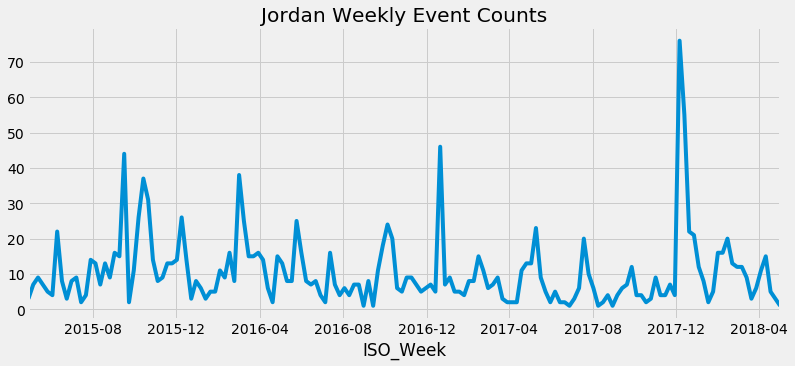

In [26]:
jo_gsr_df["ISO_Week"] = jo_gsr_df.Event_Date.apply(lambda x: parse(x).isocalendar())
jo_gsr_df["ISO_Week"] = jo_gsr_df.ISO_Week.apply(lambda x: (x[0], x[1], REFERENCE_WEEKDAY))
jo_gsr_df.ISO_Week = jo_gsr_df.ISO_Week.apply(isoweek_to_gregorian)
jo_by_week = jo_gsr_df.groupby("ISO_Week").size()
jo_by_week = jo_by_week.reindex(iso_dates).fillna(0)

jo_by_week.plot(figsize=(12,5))
title_ = "Jordan Weekly Event Counts"
plt.title(title_);
out_path = os.path.join(MCT_PLOT_PATH, "{}.png".format(title_))
plt.savefig(out_path)

In [27]:
out_path = os.path.join(MCT_CU_COUNT_PATH, "Jordan_Weekly_Counts.json")

jordan_weekly_df = pd.DataFrame({"Case_Count": jo_by_week})
jordan_weekly_df["Location"] = "Jordan"
jordan_weekly_df["Event_Date"] = [x.strftime("%Y-%m-%d") for x in jordan_weekly_df.index]
jordan_weekly_df["Event_ID"] = jordan_weekly_df.apply(lambda x: "CU_Count_Jordan_{}".format(x.Event_Date),
                                            axis=1)
jordan_weekly_df.to_json(force_ascii=False, orient="records", path_or_buf=out_path)

## Province Monthly Counts

### Amman

/anaconda3/envs/mercury/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


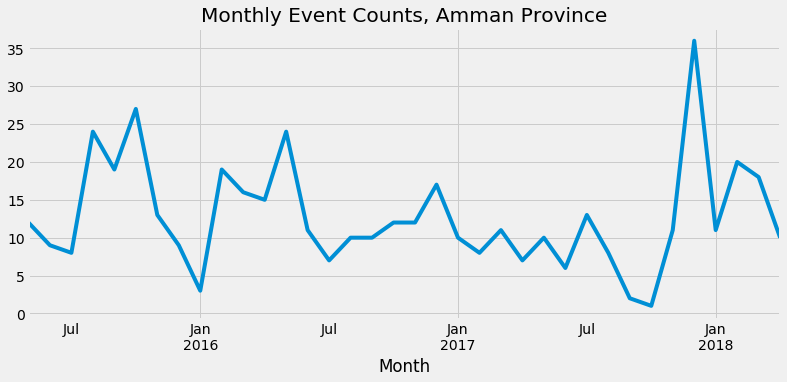

In [28]:
amman_df["Month"] = amman_df.Event_Date.apply(lambda x: parse(x).replace(day=1))
amman_by_month = amman_df.groupby("Month").size()
amman_by_month.reindex(month_dates).fillna(0)
amman_by_month.plot(figsize=(12,5))
title_ = "Monthly Event Counts, Amman Province"
plt.title(title_);
out_path = os.path.join(MCT_PLOT_PATH, "{}.png".format(title_))
plt.savefig(out_path)

In [29]:
out_path = os.path.join(MCT_CU_COUNT_PATH, "Amman_Monthly_Counts.json")

amman_monthly_df = pd.DataFrame({"Case_Count": amman_by_month})
amman_monthly_df["Location"] = "Amman"
amman_monthly_df["Event_Date"] = [x.strftime("%Y-%m-%d") for x in amman_monthly_df.index]
amman_monthly_df["Event_ID"] = amman_monthly_df.apply(lambda x: "CU_Count_Amman_{}".format(x.Event_Date),
                                            axis=1)
amman_monthly_df.to_json(force_ascii=False, orient="records", path_or_buf=out_path)

### Madaba

/anaconda3/envs/mercury/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


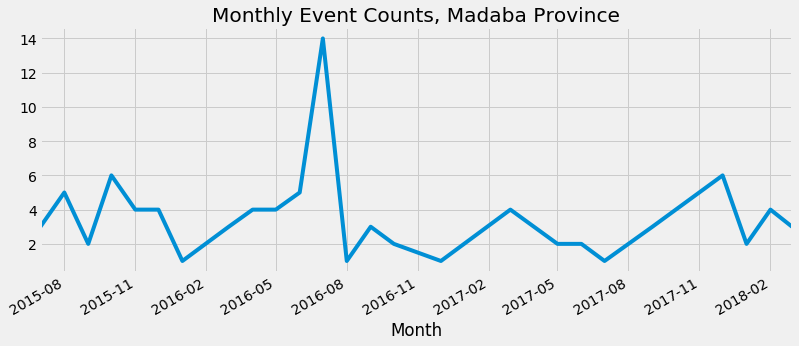

In [30]:
madaba_df["Month"] = madaba_df.Event_Date.apply(lambda x: parse(x).replace(day=1))
madaba_by_month = madaba_df.groupby("Month").size()
madaba_by_month.reindex(month_dates).fillna(0)
madaba_by_month.plot(figsize=(12,5))
title_ = "Monthly Event Counts, Madaba Province"
plt.title(title_);
out_path = os.path.join(MCT_PLOT_PATH, "{}.png".format(title_))
plt.savefig(out_path)

In [31]:
out_path = os.path.join(MCT_CU_COUNT_PATH, "Madaba_Monthly_Counts.json")

madaba_monthly_df = pd.DataFrame({"Case_Count": madaba_by_month})
madaba_monthly_df["Location"] = "Madaba"
madaba_monthly_df["Event_Date"] = [x.strftime("%Y-%m-%d") for x in madaba_monthly_df.index]
madaba_monthly_df["Event_ID"] = madaba_monthly_df.apply(lambda x: "CU_Count_Madaba_{}".format(x.Event_Date),
                                            axis=1)
madaba_monthly_df.to_json(force_ascii=False, orient="records", path_or_buf=out_path)

### Irbid

/anaconda3/envs/mercury/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


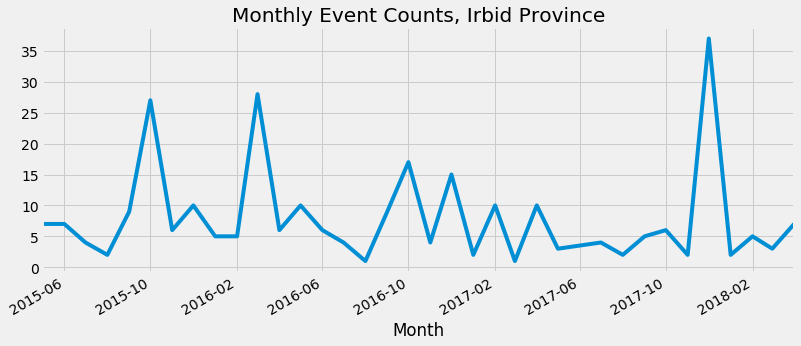

In [32]:
irbid_df["Month"] = irbid_df.Event_Date.apply(lambda x: parse(x).replace(day=1))
irbid_by_month = irbid_df.groupby("Month").size()
irbid_by_month.reindex(month_dates).fillna(0)
irbid_by_month.plot(figsize=(12,5))
title_ = "Monthly Event Counts, Irbid Province"
plt.title(title_);
out_path = os.path.join(MCT_PLOT_PATH, "{}.png".format(title_))
plt.savefig(out_path)

In [33]:
out_path = os.path.join(MCT_CU_COUNT_PATH, "Irbid_Monthly_Counts.json")

irbid_monthly_df = pd.DataFrame({"Case_Count": irbid_by_month})
irbid_monthly_df["Location"] = "Irbid"
irbid_monthly_df["Event_Date"] = [x.strftime("%Y-%m-%d") for x in irbid_monthly_df.index]
irbid_monthly_df["Event_ID"] = irbid_monthly_df.apply(lambda x: "CU_Count_Irbid_{}".format(x.Event_Date),
                                            axis=1)
irbid_monthly_df.to_json(force_ascii=False, orient="records", path_or_buf=out_path)

In [34]:
parse("2018-05-21").strftime("%B_%Y")

'May_2018'